In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from src import LorenzPINN
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sys, copy, os, shutil, time, math
from tqdm.notebook import tqdm

2024-12-26 23:32:48.568174: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 23:32:48.603963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 23:32:49.444570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 23:32:50.464481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 23:32:50.589843: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# fixed settings for this figure-making
TT, TFC, t_max, n_epochs = 0.0, 0.0, 8.0, 60000
comp_obs, active_comps = [True, True, True], "XYZ" # all components observed

# other settings
lmbda, rho, alpha, d_obs, seed = 1000.0, 28.0, 0.05, 10, 0

# load in our data, thinning based on density of observations
orig_data = pd.read_csv(f"data/LORENZ_rho={rho}_alpha={alpha}_seed={seed}.csv")
data = orig_data.query(f"t <= {t_max}")
data = data.iloc[::int((data.index.shape[0] - 1) / (d_obs * t_max))]

# extract out the time vector + noisy observations
ts_obs = data.t.values.astype(np.float64)
x_obs = data[["X_obs", "Y_obs", "Z_obs"]].to_numpy().astype(np.float64)

# make certain components missing if necessary
for i, comp_obs_val in enumerate(comp_obs):
    if comp_obs_val != True:
        x_obs[:,i] = np.nan
        
# alias to make loss calculations more intuitive
X_obs, Y_obs, Z_obs = x_obs[:,0:1], x_obs[:,1:2], x_obs[:,2:3]
        
# create our lorenz_data structure that the PINN needs (USING NOISED OBSERVATIONS)
lorenz_data = [ts_obs.reshape(-1, 1), X_obs, Y_obs, Z_obs]

In [3]:
# set a seed for reproducibility
tf.random.set_seed(seed)

# dataframe to store our results
logs = pd.DataFrame(data=None, columns=["epoch", "beta", "rho", "sigma", 
                                        "total_loss", "l2_X", "l2_Y", "l2_Z", 
                                        "physics_X", "physics_Y", "physics_Z"])

# they are doing batch-norm and log-transforming all of their beta, rho, and sigma (showcased settings)
pinn = LorenzPINN(bn=True, log_opt=True, lr=1e-2, layers=3, 
                  layer_width=32, lmbda=lmbda)

# reference points for physics-based loss evaluation
t_max_pred = 8.0 # purely concerned with in-sample!
t_physics = tf.convert_to_tensor(np.linspace(TT, t_max_pred, 
                                             int(((t_max_pred - TT) * 40) + 1))\
                                 .reshape(-1, 1))

# make a directory
foldername = f"lmbda={lmbda}_rho={rho}_alpha={alpha}_dobs={d_obs}_seed={seed}"
if foldername not in os.listdir("results/pinn_over_time"):
    os.mkdir(f"results/pinn_over_time/{foldername}")
if "trajs_over_time" not in os.listdir(f"results/pinn_over_time/{foldername}"):
    os.mkdir(f"results/pinn_over_time/{foldername}/trajs_over_time")

In [4]:
# train the PINN for 60K epochs ON IN-SAMPLE OBSERVATIONS ONLY!
for epoch in tqdm(range(n_epochs)):

    # one optimization step (we're not forecasting!)
    pinn.fit(observed_data=lorenz_data, 
             TT=TT, TM=t_max_pred, TFC=TFC, is_forecasting=False,
             epochs=1, verbose=False, active_comps=active_comps)
    
    # get our theta_hat = (beta, rho, sigma) at this epoch
    beta_hat = np.exp(pinn.c3.value.numpy())
    rho_hat = np.exp(pinn.c2.value.numpy())
    sigma_hat = np.exp(pinn.c1.value.numpy())
    theta_hat = np.array([beta_hat, rho_hat, sigma_hat])
    
    # get our in-sample predictions + convert to numpy
    X_hat, Y_hat, Z_hat = pinn.NN(lorenz_data[0])
    X_hat, Y_hat, Z_hat = X_hat.numpy(), Y_hat.numpy(), Z_hat.numpy()
    
    # L2-losses (X, Y, Z) - will nan out if needed
    l2_X = ((X_hat - X_obs) ** 2).mean()
    l2_Y = ((Y_hat - Y_obs) ** 2).mean()
    l2_Z = ((Z_hat - Z_obs) ** 2).mean()
    
    # physics-based losses
    with tf.GradientTape(persistent=True) as g:
        g.watch(t_physics)
        [X_physics, Y_physics, Z_physics] = pinn.NN(t_physics)

    # gradients w.r.t. t_physics (implied by autograd)
    dXdt_agd = g.gradient(X_physics, t_physics).numpy()
    dYdt_agd = g.gradient(Y_physics, t_physics).numpy()
    dZdt_agd = g.gradient(Z_physics, t_physics).numpy()
    
    # convert the physics outputs to numpy
    X_physics = X_physics.numpy()
    Y_physics = Y_physics.numpy()
    Z_physics = Z_physics.numpy()
    
    # what are the ODE-based derivatives?
    dXdt_phys = sigma_hat * (Y_physics - X_physics)
    dYdt_phys = (X_physics * (rho_hat - Z_physics)) - Y_physics
    dZdt_phys = (X_physics * Y_physics) - (beta_hat * Z_physics)
    
    # compute physics-based loss per component
    physics_X = ((dXdt_agd - dXdt_phys) ** 2).mean()
    physics_Y = ((dYdt_agd - dYdt_phys) ** 2).mean()
    physics_Z = ((dZdt_agd - dZdt_phys) ** 2).mean()
    
    # what's our total loss?
    total_loss = (lmbda * np.nansum([l2_X, l2_Y, l2_Z])) + (physics_X + physics_Y + physics_Z)
    
    # record epoch, beta, rho, sigma, total loss, L2-loss (X, Y, Z), physics-loss (X, Y, Z).
    row = [epoch] + list(theta_hat) + [total_loss, l2_X, l2_Y, l2_Z, physics_X, physics_Y, physics_Z]
    logs.loc[len(logs.index)] = row
    
    # every 1000 epochs, record the trajectories on the interval
    if ((epoch + 1) % 1000) == 0:
    
        interval_preds = pd.DataFrame(data=np.hstack([t_physics, X_physics, Y_physics, Z_physics]),
                                      columns=["t", "X", "Y", "Z"])
        interval_preds.to_csv(f"results/pinn_over_time/{foldername}/trajs_over_time/{str(epoch + 1).zfill(5)}.csv", index=False)

  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
'''
Need to save the following:
1. Logs of loss decomposition + params over time.
2. Model weights of final PINN's NN layers.
3. Point estimates of theta 
4. Point predictions on (X, Y, Z) at in-sample timesteps
5. Physics-based Residuals (autograd minus ODE-implied)
6. Raw data.
7. Interval inferred trajectories (including forecasted, if called for)
'''

# 1. start with the loss logs
logs.to_csv(f"results/pinn_over_time/{foldername}/logs.csv", index=False)

# 2. PINN weights after last epoch.
pinn.NN.save_weights(f"results/pinn_over_time/{foldername}/pinn.weights.h5")

# 3. final estimate of theta_hat
theta_hat_final = pd.DataFrame(data=theta_hat.reshape(1, -1), columns=["beta", "rho", "sigma"])
theta_hat_final.to_csv(f"results/pinn_over_time/{foldername}/theta_hats.csv", index=False)

# 4. in-sample predictions of (X, Y, Z)
preds = pd.DataFrame(data=np.hstack([lorenz_data[0], X_hat, Y_hat, Z_hat]), columns=["t", "X", "Y", "Z"])
preds.to_csv(f"results/pinn_over_time/{foldername}/in-sample_preds.csv", index=False)

# 5. physics-residuals
physics_residuals = np.hstack([t_physics, dXdt_agd - dXdt_phys, dYdt_agd - dYdt_phys, dZdt_agd - dZdt_phys])
physics_logs = pd.DataFrame(data=physics_residuals, columns=["t", "X", "Y", "Z"]) # agd minus implied
physics_logs.to_csv(f"results/pinn_over_time/{foldername}/physics_residuals.csv", index=False)

# 6. noisy observations
noisy_obs = pd.DataFrame(data=np.hstack([ts_obs.reshape(-1, 1), X_obs, Y_obs, Z_obs]), 
                         columns=["t", "X", "Y", "Z"])
noisy_obs.to_csv(f"results/pinn_over_time/{foldername}/noisy_obs.csv", index=False)

# 7. out-of-sample predictions
oos_preds = pd.DataFrame(data=np.hstack([t_physics, np.hstack(pinn.NN(t_physics))]), 
                         columns=["t", "X", "Y", "Z"])
oos_preds.to_csv(f"results/pinn_over_time/{foldername}/oos_preds.csv", index=False)

# Visualize Trajectories Over Time: PINN Slow To Converge!

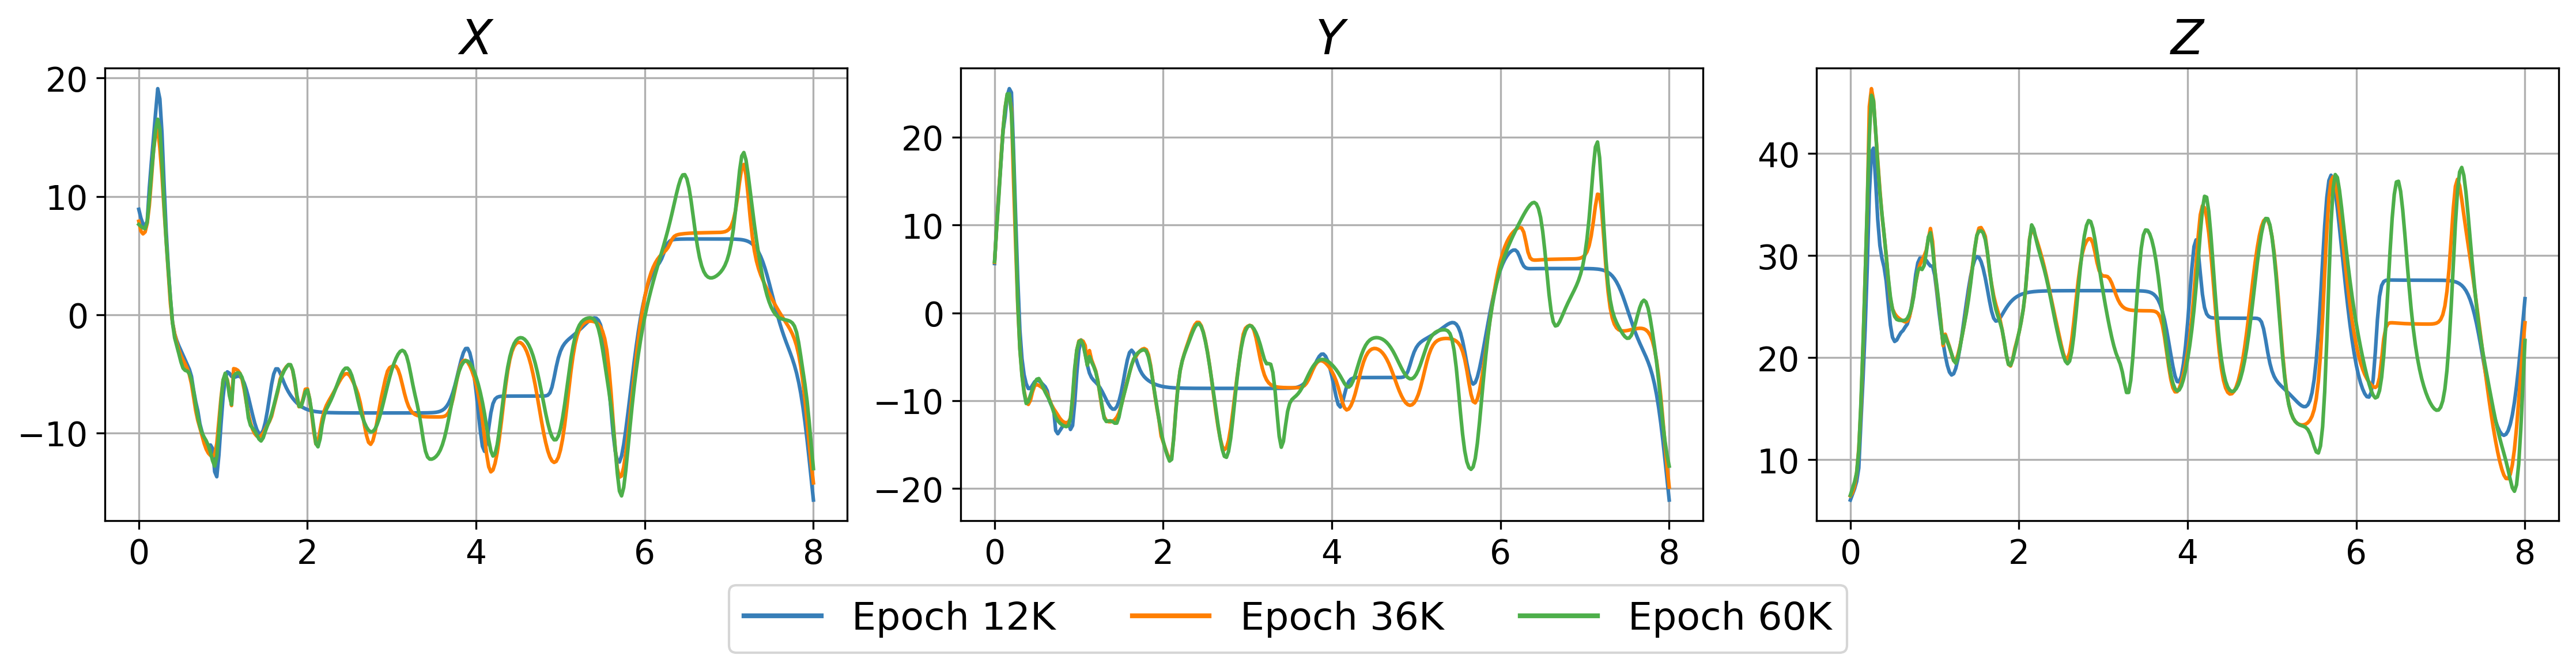

In [2]:
# colorblind-friendly colors
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
a = "a"

# get our folder, plot the trajectories over time
foldername = "results/pinn_over_time/lmbda=1000.0_rho=28.0_alpha=0.05_dobs=10_seed=0"

# get our noisy obs too
noisy_obs = pd.read_csv(f"{foldername}/noisy_obs.csv")

# create our figure
fig, ax = plt.subplots(1, 3, dpi=300, figsize=(15, 3.5))

# load in each of our files (12K epochs apart)
for i, epoch in enumerate([12000, 36000, 60000]):
    
    # load in the corresponding prediction file
    str_epoch = str(epoch).zfill(5)
    preds = pd.read_csv(f"{foldername}/trajs_over_time/{str_epoch}.csv")
    
    # go thru each of our subplots
    for j, comp in enumerate(["X", "Y", "Z"]):
        
        # initial beautifying
        if i == 0:
            ax[j].grid()
            ax[j].tick_params("both", labelsize=14)
        
        ax[j].plot(preds["t"], preds[comp], color=colors[i], linestyle=["--", "-.", None][i], linewidth=2.0)
        ax[j].set_title(f"${comp}$", fontsize=20)

# create custom legend
custom_lines = [
    Line2D([0], [0], color=colors[0], linewidth=2.0, alpha=1.0, label=f"Epoch 12K", linestyle="--"),
    Line2D([0], [0], color=colors[1], linewidth=2.0, alpha=1.0, label=f"Epoch 36K", linestyle="-."),
    Line2D([0], [0], color=colors[2], linewidth=2.0, alpha=1.0, label=f"Epoch 60K", linestyle=None),
]
fig.legend(handles=custom_lines, loc="lower center", ncol=3, fontsize=16, bbox_to_anchor=(0.5, -0.125))
plt.tight_layout()
plt.savefig("camera_ready/trajectories/trajs_over_epoch.jpg", facecolor="white", bbox_inches="tight")
plt.show()